In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline  

import torch
import torch.nn as nn

import torch.optim as optim

from copy import deepcopy

from torch.distributions import Categorical, Normal

import itertools

import sys
sys.path.insert(0, './../libraries/')

import partial_marginalization_lib as pm_lib
import galaxy_experiments_lib as galaxy_lib
import importance_sample_lib as imp_lib

import sys
sys.path.insert(0, '../../../celeste_net/')
import celeste_net 

from celeste_net import OneGalaxyVAE


from datasets import Synthetic

# Load data

In [2]:
side_len = 31

In [3]:
galaxy_data = Synthetic(side_len, min_galaxies=1, max_galaxies=1, num_bands=5, num_images=50, 
                        brightness = 30000)

In [4]:
train_loader, test_loader = galaxy_lib.get_train_test_data(galaxy_data, batch_size=10)

In [5]:
for batch_idx, data in enumerate(train_loader):
    train_data_batch1 = data
    break
    
images_batch1 = train_data_batch1['image']
backgrounds_batch1 = train_data_batch1['background']

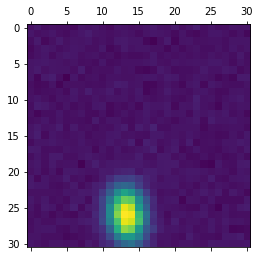

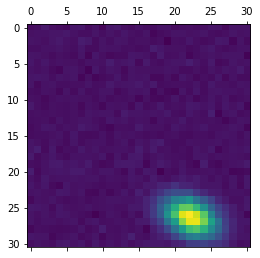

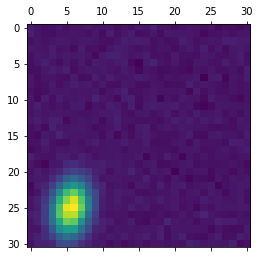

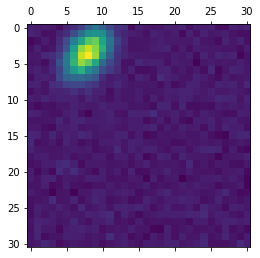

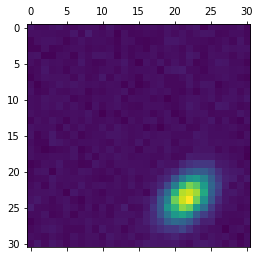

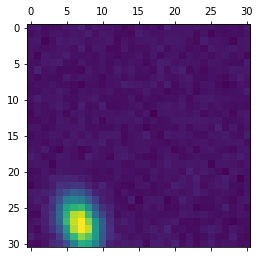

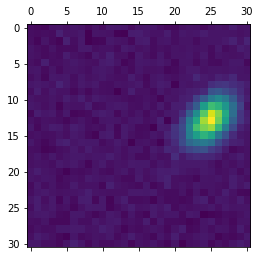

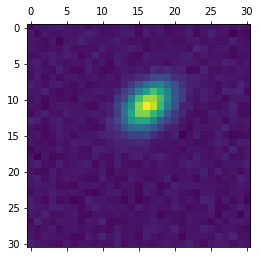

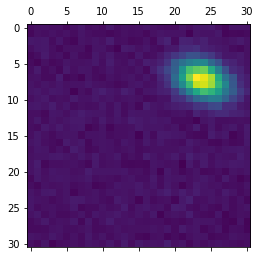

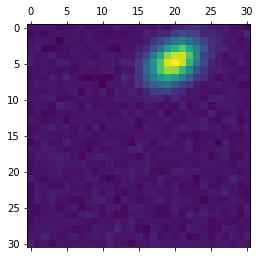

In [6]:
for i in range(images_batch1.shape[0]): 
    plt.matshow(images_batch1[i, 0, :, :])

In [7]:
imp_weights = imp_lib.get_importance_weights(images_batch1, attn_offset=4, prob_off=0.5)

# The VAE

In [8]:
galaxy_vae = celeste_net.OneGalaxyVAE(side_len)

In [9]:
# state_dict = torch.load("./galaxy_vae.dat", map_location='cpu')
# # state_dict = torch.load("../galaxy_results/test_epoch80.dat", map_location='cpu')

# galaxy_vae.load_state_dict(state_dict, strict=False)

galaxy_vae.eval(); 

In [10]:
galaxy_rnn = galaxy_lib.CelesteRNN(side_len, one_galaxy_vae=galaxy_vae)

In [11]:
pixel_probs = galaxy_rnn.get_pixel_probs(images_batch1, backgrounds_batch1)

In [12]:
map_pixel_loc = torch.argmax(pixel_probs, dim=1)

In [13]:
cond_loss, recon_mean, recon_var = galaxy_rnn.get_loss_conditional_a(
                                            resid_image = images_batch1 - backgrounds_batch1, 
                                            image_so_far = backgrounds_batch1, 
                                            var_so_far = backgrounds_batch1, 
                                            pixel_1d = map_pixel_loc)

In [14]:
map_pixel_loc

tensor([ 529,  529,  529,  529,  529,  529,  529,  529,  529,  529])

(array([529.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.]),
 array([1.00621571e-06, 5.51132735e-02, 1.10225541e-01, 1.65337808e-01,
        2.20450075e-01, 2.75562342e-01, 3.30674610e-01, 3.85786877e-01,
        4.40899144e-01, 4.96011411e-01, 5.51123679e-01]),
 <a list of 10 Patch objects>)

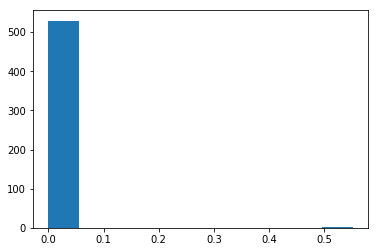

In [15]:
plt.hist(pixel_probs[0, :].detach())

In [16]:
recon_mean.sum()

tensor(3.3635e+07)

In [17]:
recon_var.sum()

tensor(3.3635e+07)

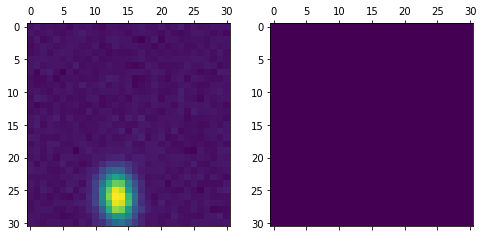

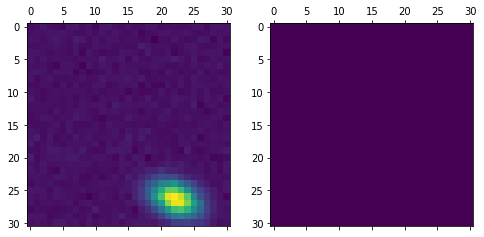

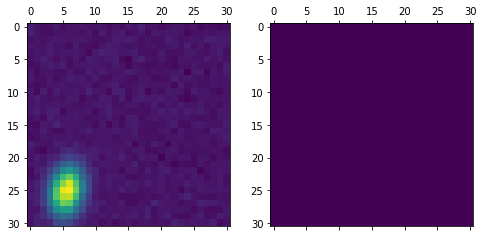

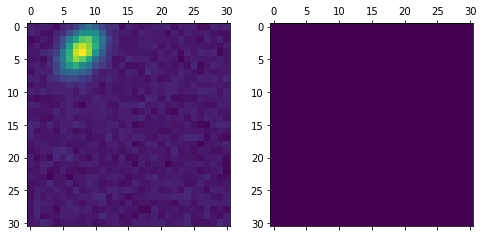

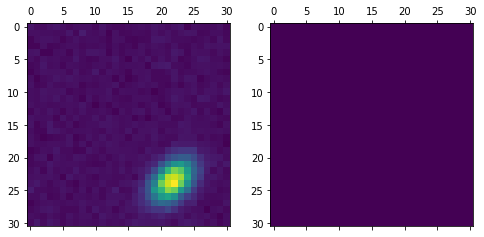

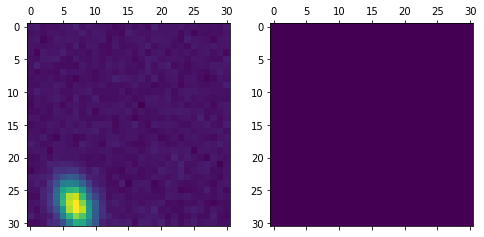

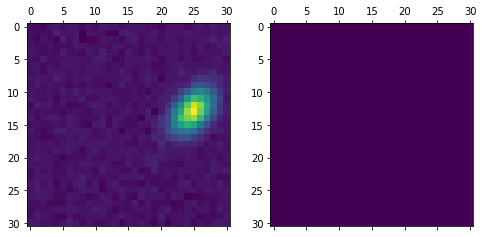

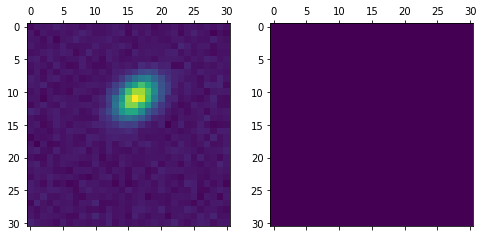

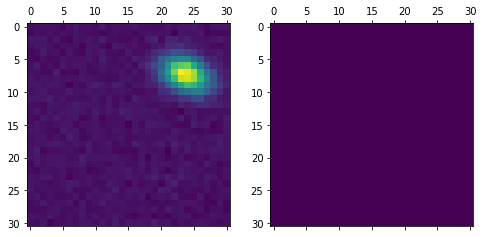

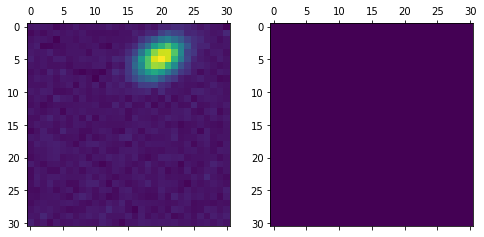

In [18]:
figsize = 8

for n in range(images_batch1.shape[0]): 
    f, axarr = plt.subplots(1, 2, figsize=(figsize, figsize))

    axarr[0].matshow(images_batch1[n, 0, :, :].squeeze())
    axarr[1].matshow(recon_mean.detach()[n, 0, :, :].squeeze())


In [19]:
# Experimenting with new importance sampling functions

In [20]:
attn_offset = galaxy_rnn.attn_offset

normalized_image = imp_lib.get_normalized_image(images_batch1, attn_offset)

In [21]:
normalized_image.sum(dim = 1).sum(dim = 1) - 1

tensor(1.00000e-07 *
       [ 1.1921,  1.1921,  0.0000,  0.0000,  1.1921,  0.0000,  0.0000,
        -1.1921,  0.0000,  0.0000])

In [22]:
prob_off = pixel_probs.detach()[:, -1].view(-1, 1)
importance_weights = \
    imp_lib.get_importance_weights(images_batch1, attn_offset, prob_off)

In [23]:
np.max(np.abs(importance_weights.numpy().sum(1) - 1.0))

1.1920929e-07

In [24]:
print(np.abs(importance_weights.numpy().sum(1) - 1.0))

[0.0000000e+00 1.1920929e-07 0.0000000e+00 0.0000000e+00 0.0000000e+00
 0.0000000e+00 5.9604645e-08 5.9604645e-08 0.0000000e+00 0.0000000e+00]


In [25]:
assert np.max(np.abs(importance_weights[:, -1].numpy() - prob_off.numpy().squeeze())) < 1e-16
assert np.max(np.abs(importance_weights.numpy().sum(1) - 1.0)) < 1e-6

In [26]:
# check optimizer goes through

In [27]:
optimizer = optim.Adam(galaxy_rnn.parameters(), lr=0.001, weight_decay=1e-6)
optimizer.zero_grad()

In [28]:
pm_loss, map_loss = imp_lib.importance_sampled_galaxy_loss(galaxy_rnn, images_batch1, backgrounds_batch1,
                                    backgrounds_batch1,
                                    use_importance_sample = True,
                                    use_baseline = True)

In [29]:
pm_loss

tensor(3.1082e+07)

In [30]:
map_loss

tensor(3.0852e+06)

In [31]:
pm_loss.backward()

In [32]:
optimizer.step()

In [33]:
_, map_loss2 = galaxy_rnn.get_pm_loss(images_batch1, 
                                           backgrounds_batch1, 
                                           backgrounds_batch1, 
                                           alpha = 0.0, 
                                           topk = 5, 
                                           use_baseline = True, 
                                     use_term_one_baseline = False)

In [34]:
map_loss2

tensor(1.00000e+06 *
       3.0852)

In [35]:
# Check train module

In [ ]:
galaxy_lib.train_module(galaxy_rnn, train_loader, test_loader, epochs = 12, save_every = 2, 
                        alpha = 0.0, topk = 0, use_baseline = True, use_term_one_baseline = False, n_samples = 2,
                        lr = 1e-4, weight_decay = 1e-6,
                        filename = './test',
                        seed = 245345)

In [ ]:
# check we can load it back

galaxy_vae_reload = celeste_net.OneGalaxyVAE(side_len)
state_dict = torch.load("./test_epoch10.dat", map_location='cpu')
galaxy_vae_reload.load_state_dict(state_dict, strict=False)

galaxy_vae_reload.eval(); 

In [ ]:
galaxy_vae_reload

In [ ]:
np.load('./test_losses_array.npy')